# Pricing equity index options
In this notebook I price equity index options using volatility tracking, riskless yield curve construction, and options pricing code from this package. I ensure that all market and economic data required for pricing is obtained from [FRED](https://fred.stlouisfed.org) and [Yahoo-finance](https://finance.yahoo.com) using [pandas-datareader](https://pydata.github.io/pandas-datareader/). Since the lifetime of an option is usually measured using trading
days rather than calendar days, I make use of [the pandas-market-calendars library](https://pandas-market-calendars.readthedocs.io/en/latest/index.html) to get correct trading calendars.

This notebook can also be used as a tutorial to using the `pricing.curves`, `pricing.options`, `volatility.parameter_estimators`, and `volatility.volatility_trackers` packages in this repository.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/options-pricing.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas-datareader and yfinance
# !pip install pandas-datareader -U
# !pip install yfinance -U
# !pip install pandas-market-calendars -U

## Constructing a riskless spot rate curve for USD
Since I already covered it in a separate notebook, I will simply import it. The resultant `YieldCurve` object is assigned to the curve variable.

I prepared two alternative riskless rate curves &mdash; one based on US Treasury Yields converted into their corresponding spot rates (you can use it for pricing options maturing up to 30 years in the future) and another based on AMERIBOR rates (you can use it for pricing options maturing up to 2 years in the future). Since AMERIBOR term structure is no longer published by the Federal Reserve Bank of St. Louis, it cannot be used anymore unfortunately...

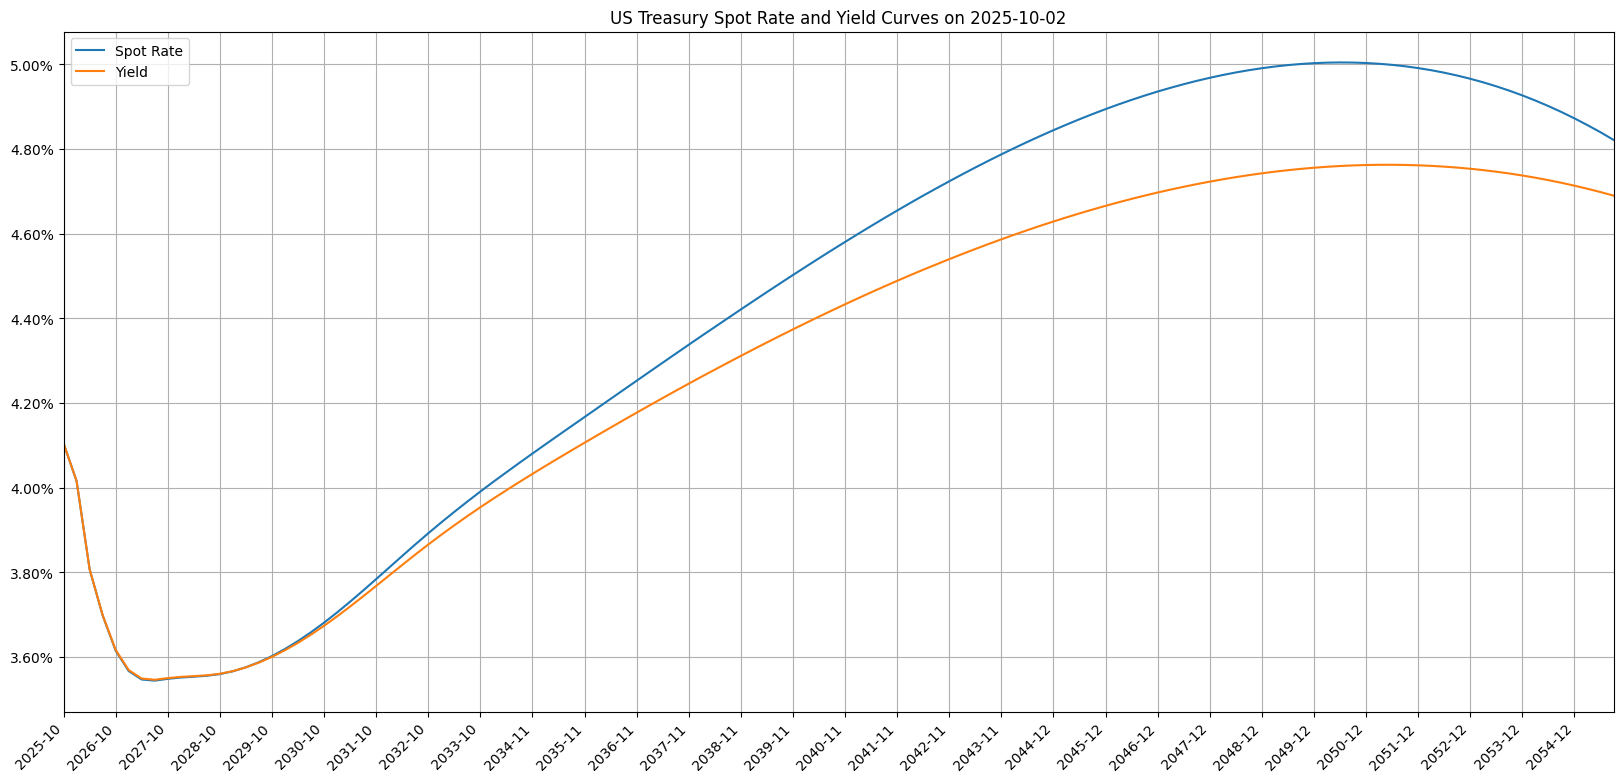

In [2]:
# Uncomment the below line if you want to price with a yield curve based on US Treasury Yields
%run riskless-spot-rate-curve-construction-example.ipynb

# Uncomment the below line if you want to price with a yield curve based on AMERIBOR rates
#%run riskless-rate-curve-construction-ameribor.ipynb

## Estimating and forecasting volatility of the index, options on which we want to price
Now that the riskless curve has been constructed, the next thing to do is obtain an accurate volatility estimate for the index whose options we want to price. There are various methods for doing it. The most common are the Exponentially Weighted Moving Average (EWMA) and GARCH(1, 1) methods. You can read about them on the Internet or delve into John C. Hull's [Risk Management and Financial Institutions](http://www-2.rotman.utoronto.ca/~hull/riskman/index.html) or [Options, Futures, and Other Derivatives](http://www-2.rotman.utoronto.ca/~hull/ofod/index.html). For the purposes of pricing options GARCH(1, 1) is preferred because it supports volatility forecasting for future maturities by incorporating mean reversion (and volatility of equities lends itself to mean reversion). In this notebook I therefore use GARCH(1, 1).

### GARCH(1, 1)
In order to use GARCH(1, 1) one first needs to estimate its parameters based on the historical data for the equity whose options you want to price. GARCH(1, 1) has three parameters &mdash; ω, α, and β. I use the maximum likelihood method to estimate them, which is an optimization task. The `volatility.parameter_estimators.GARCHParameterEstimator` class comes to rescure. _Implementation detail_: In that class I use [SciPy](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) to optimize for maximum likelihood. Alternatively I could've used Google's TensorFlow 2.x.

Constraint optimization for three variables is not fast. If you are not content with the speed of `volatility.parameter_estimators.GARCHParameterEstimator`, you can use its `volatility.parameter_estimators.GARCHVarianceTargetingParameterEstimator` counterpart. This latter class is 
faster because it uses the so-called _variance targeting_ method whereby it sets ω based on the sample variance of price changes. Then it optimises for only two variables instead of three as GARCHParameterEstimator does. It's marginally less accurate.

*NB* When estimating ω, α, and β it's vital to use _adjusted closing_ prices, i.e. prices that have been adjusted for dividends and stock splits. Failing to do that will result in too high an estimate. Yahoo Finance provides such prices in the `Adj Close` column.

#### Estimating GARCH(1, 1) parameters for S&P 500 (^GSPC)
Since volatility tends to change with time, it's recommended to estimate it based on the most recent 90 or 180 days, or on the same number of days as the duration of the option being priced. In this notebook I use data from the past two years.

In [3]:
TICKER = '^GSPC'

# I'll use price changes over the past two years to estimate GARCH(1, 1) ω, α, and β parameters
start = BDay(1).rollback(date.today() - relativedelta(years=+2))
data = yfin.Ticker(TICKER).history(start=start, actions=False, auto_adjust=False)
asset_prices = data['Adj Close']

vol_estimator = parameter_estimators.GARCHParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta))

Objective function: 4255.07058 after 118 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000004417824, α=0.13004, β=0.82276


##### Optional: Estimating with a faster estimator &mdash; GARCHVarianceTargetingParameterEstimator

In [4]:
var_target_vol_estimator = parameter_estimators.GARCHVarianceTargetingParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (var_target_vol_estimator.omega, var_target_vol_estimator.alpha, var_target_vol_estimator.beta))

Objective function: 4255.01948 after 103 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000004331030, α=0.13370, β=0.82309


As you can see, `GARCHParameterEstimator` is able to achieve a slightly higher value of the objective function than `GARCHVarianceTargetingParameterEstimator`. The higher, the more accurate as we are solving for the maximum value. I will therefore use `GARCHParameterEstimator` in the rest of this notebook.

#### Forecasting volatility for S&P 500
Now that we have obtained the optimal GARCH(1, 1) parameter values&mdash;ω, α, and β&mdash;we can proceed to forecast S&P 500 volatility. I have created the `volatility.parameter_estimators.GARCHVolatilityTracker` class to assist with this.

In [5]:
vol_tracker = volatility_trackers.GARCHVolatilityTracker(vol_estimator.omega, vol_estimator.alpha,
                                                         vol_estimator.beta, asset_prices)

# The 3rd Friday of next March, i.e. the 3rd Friday of next March
from dateutil.relativedelta import FR
maturity_date = curve.date + relativedelta(years=0 if curve.date.month < 3 else 1, month=3, day=1, weekday=FR(3))
vol = vol_tracker.get_annual_term_volatility_forecast(curve.to_years(maturity_date))
print('Volatility of %s for term %.4f years: %.5f' % (TICKER, curve.to_years(maturity_date), vol))

Volatility of ^GSPC for term 0.4521 years: 0.14445


#### Optional: Visualizing historical and future volatility of S&P 500 for 200 business days into the future

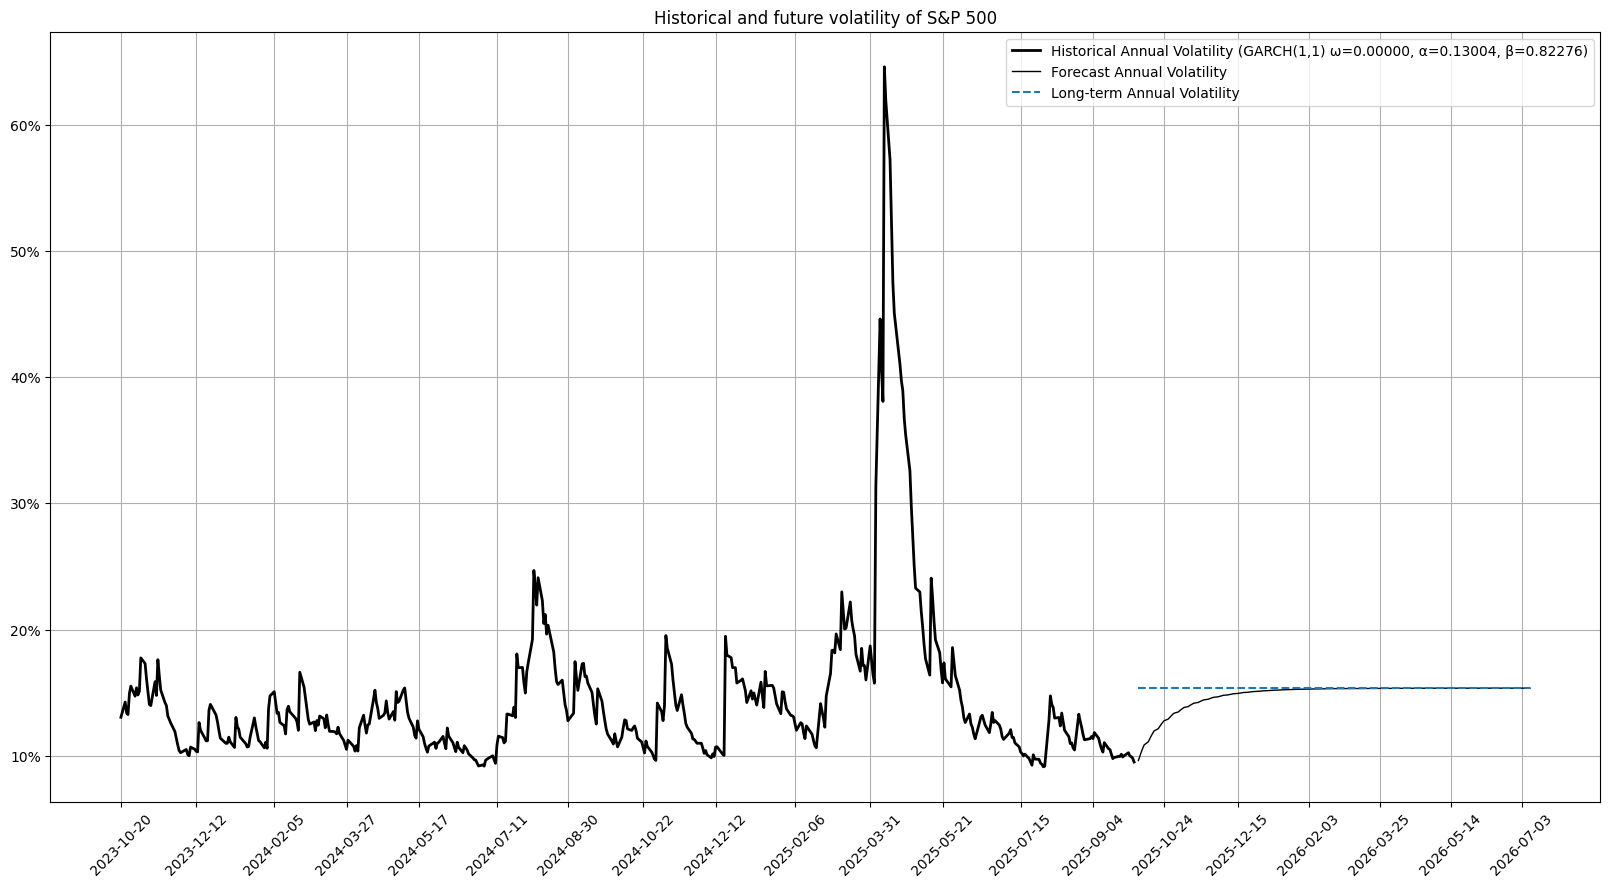

In [6]:
import matplotlib.pyplot as plt

# Skipping the first n days of volatility forecast
n_days_to_skip = 10
x = vol_tracker.get_dates()[n_days_to_skip:]
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, vol_tracker.get_annual_volatilities()[n_days_to_skip:],
        label='Historical Annual Volatility (GARCH(1,1) ω=%.5f, α=%.5f, β=%.5f)' 
            % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta),
        linewidth=2, color='k')

# Forecasting volatility of Apple stock 200 days into the future
future_volatilities = vol_tracker.get_annual_volatility_forecast_for_next_n_days(200)
ax.plot(future_volatilities.index, future_volatilities, label='Forecast Annual Volatility', linewidth=1, color='k')
ax.hlines(vol_tracker.get_annual_long_term_volatility(), xmin=future_volatilities.index[0], xmax=future_volatilities.index[-1],
         label="Long-term Annual Volatility", linestyle='--')
ax.legend()
ax.grid(True)
ax.set_title('Historical and future volatility of S&P 500')
x_axis = x.append(future_volatilities.index)
ax.set_xticks(x_axis[::36])
ax.set_xticklabels(x_axis[::36].strftime('%Y-%m-%d'), rotation=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

#### Optional: Visualizing volatility term structure of the S&P 500 index over the next 5 years
In contrast to the `equity-options-pricing-example.ipynb` notebook where I visualized historical, and future volatilities, in this notebook I'll visualize the _volatility term structure_ for S&P 500, i.e. forecast average volatility for a certain future term expressed in years. Given the mean reverting nature of volatility, volatility for the longer terms trends towards the mean volatility of a given asset.

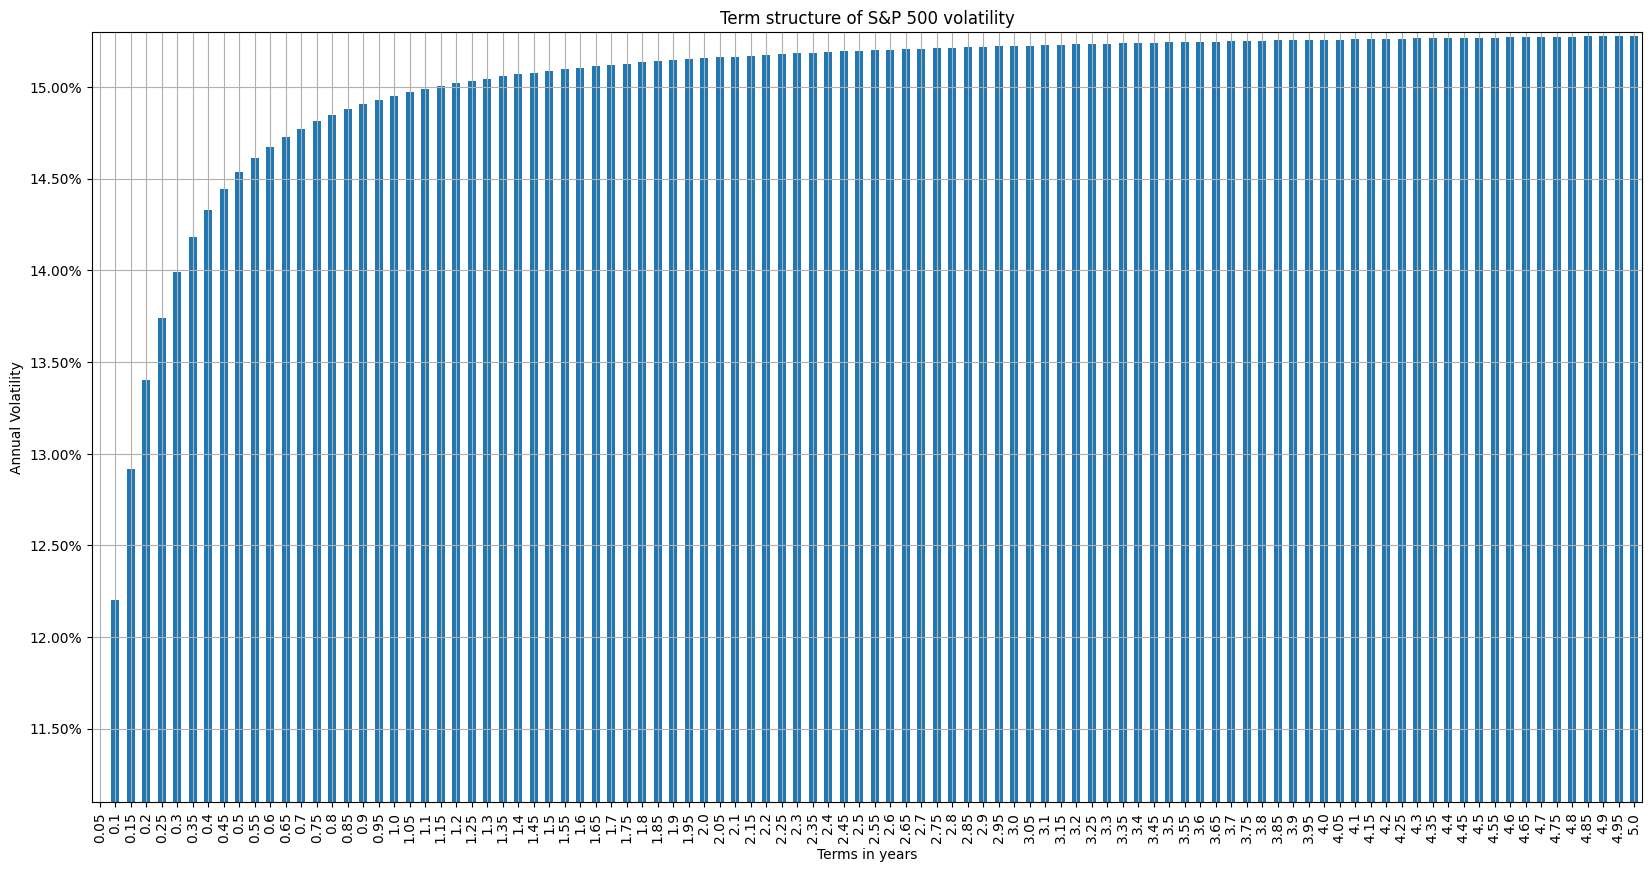

In [7]:
from math import floor, ceil

terms = [x / 100 for x in range(5, 505, 5)]
term_vols = [vol_tracker.get_annual_term_volatility_forecast(term) * 100 for term in terms]
series = pd.Series(term_vols, index=terms)

ax = series.plot(figsize=(20,10), grid=True, kind='bar', title='Term structure of S&P 500 volatility')
ax.set_ylim(bottom=floor(series.min()*10) / 10, top=ceil(series.max()*10) /10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Annual Volatility')
_ = ax.set_xlabel('Terms in years')

## Pricing using Black-Scholes-Merton Pricer
The Black-Scholes-Merton model can be used to price European options, including equity indices. With enough customizations it can also be used to price American call options (even those paying dividends or having a known
dividend yield). Exchange and over-the-counter traded equity index options tend to be European.

Let's put it to use to price an S&P 500 call and put options with a strike of 3900. Some of the stocks comprising S&P 500 pay dividends. It's essential to take into account the expected dividend yield of S&P 500 to achieve accurate pricing. Where do you get S&P 500's dividend yield? I calculate it based on the forward dividend yields of individual S&P 500 companies in [this notebook](https://github.com/ilchen/US_Economic_Data_Analysis/blob/main/Stock_Market.ipynb). By running that notebook (please clone the corresponding repository), you will be able to obtain the forward dividend yield for the last business day. The class I use to calculate it [is here](https://github.com/ilchen/US_Economic_Data_Analysis/blob/main/stock_market/metrics.py#L13-L217). Alternatively, at the start of every month Aswath Damodaran @AswathDamodaran calculates the so-called equity risk premium (ERP) for S&P 500 and publishes it for download as a spreadsheet from [his website at STERN](https://pages.stern.nyu.edu/~adamodar/). `Spreadsheet to compute current ERP for current month`. From the date on S&P 500 dividends in tab `Buyback & Dividend computation`, you can
calculate the current dividend yield as well as it's estimate for the next months.

Market makers tend to calculate the life time of options using trading days rather than calendar days. The `pricing.options.BlackScholesMertonPricer` class supports both ways of pricing options. It's determined by the `holidays` parameter of its constructor, passing an array of `datetime64[D]` values implies calculating the life of
the option using the number trading days to its expiry and dividing by 252. Not passing a value for this parameter
will imply calculating the life of he option using the number of calendar days to its expiry and dividing by a value between 365 and 366. For pricing options on SP500, whose underlying futures are traded allmost on all non-weekend days, whether to use a custom trading calendar or not doesn't make a big difference on the pricing. Therefore in this notebook I use calendar days for calculating the lifetime of options. If you want to price with it, please make use of the holidays calendar created in the below cell.

In [8]:
# Taking the trading calendar into account when pricing
import pandas_market_calendars as mcal
holidays = mcal.get_calendar('NYSE').holidays().holidays

In [9]:
strike = 4500.

# Expected S&P 500 dividend yield
# q = 0.014823334573810767 # Updated for 9th April 2025
# q = 0.013103892007716863 # Updated for 16th May 2025
# q = 0.012913918866967211 # Updated for 6th June 2025
# q = 0.01252441732711993 # Updated for 2025-07-11
q = 0.01164468897329131 # Updated for 2025-10-03
cur_price = asset_prices.iloc[-1]
pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                          ticker=TICKER, q=q)
print(pricer)

put_pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price, is_call=False,
                                              ticker=TICKER, q=q)
print(put_pricer)

^GSPC EUROPEAN call option with strike 4500.0 and maturity 2026-03-20, price: 2257.10, σ: 0.1445, Δ: 0.995, Γ: 0.000, ν: 0.178
^GSPC EUROPEAN put option with strike 4500.0 and maturity 2026-03-20, price: 0.00, σ: 0.1445, Δ: -0.000, Γ: 0.000, ν: 0.178


Sometimes you might want to price using _an implied volatility_ for the expiry date, implied volatilities are volatilities implied by option prices of market makers. You can easily use implied volatilities with 
the `BlackScholesMertonPricer` class, just pass the volatility value as the second parameter instead of
a volatility tracker (I also use a custom trading calendar in the below cell):

In [10]:
impl_vol = .21

pricer = options.BlackScholesMertonPricer(maturity_date, impl_vol, strike, curve, cur_price,
                                          ticker=TICKER, q=q, holidays=holidays)
print(pricer)

put_pricer = options.BlackScholesMertonPricer(maturity_date, impl_vol, strike, curve, cur_price, is_call=False,
                                              ticker=TICKER, q=q, holidays=holidays)
print(put_pricer)

^GSPC EUROPEAN call option with strike 4500.0 and maturity 2026-03-20, price: 2257.51, σ: 0.2100, Δ: 0.993, Γ: 0.000, ν: 20.543
^GSPC EUROPEAN put option with strike 4500.0 and maturity 2026-03-20, price: 0.39, σ: 0.2100, Δ: -0.001, Γ: 0.000, ν: 20.543


#### Put-Call Parity
An important theoretical property of the price of a European option is the so-called put-call parity, which is expressed as:
$$c - p = S_0\cdot e^{-q\cdot T} - K\cdot e^{-r\cdot T}$$
where:
* c is the price of a European call option
* p is the price of the corresponding European put option
* S<sub>0</sub> is the present price of the underlying stock
* q is the expected dividend yield of the index
* K is the strike price
* T is the liefteime of the option expressed in years
* r is the riskless rate for maturity T

Let's put it to the test:

In [11]:
from math import exp
price_difference = pricer.get_price() - put_pricer.get_price()

right_hand_side_expr = pricer.s0 * exp(-pricer.q * pricer.T) - pricer.strike * exp(-pricer.r * pricer.T)

assert np.allclose(price_difference, right_hand_side_expr, .1)
print(f'Put-Call parity: {price_difference:.2f} = {right_hand_side_expr:.2f}')

Put-Call parity: 2257.13 = 2257.13


## Pricing using Binomial Tree Pricer
The Binomial Tree model can be used to price any European or American option, including on index some of whose constituent stocks pay dividends.

Let's put it to use to price an S&P 500 call and put option with a strike of 3900 and compare resulting prices with those obtained from the BlackScholesMertonPricer.

In [12]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price,
                                             ticker=TICKER, q=q)
print(bin_tree_pricer)

print('Price difference between Black-Scholes-Merton and Binomial Treee pricers for calls: %.6f'
      % abs(pricer.get_price() - bin_tree_pricer.get_price()))
bin_tree_put_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, q=q)
print(bin_tree_put_pricer)

print('Price difference between Black-Scholes-Merton and Binomial Treee pricers for puts: %.6f'
      % abs(put_pricer.get_price() - bin_tree_put_pricer.get_price()))

^GSPC EUROPEAN call option with strike 4500.0 and maturity 2026-03-20, price: 2257.41, σ: 0.2100, Δ: 0.994, Γ: 0.000, ν: 11.550
Price difference between Black-Scholes-Merton and Binomial Treee pricers for calls: 0.107574
^GSPC EUROPEAN put option with strike 4500.0 and maturity 2026-03-20, price: 0.29, σ: 0.2100, Δ: -0.001, Γ: 0.000, ν: 11.550
Price difference between Black-Scholes-Merton and Binomial Treee pricers for puts: 0.100247


Now pricing with our volatility forecast:

In [13]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                             ticker=TICKER, q=q)
print(bin_tree_pricer)

bin_tree_put_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, q=q)
print(bin_tree_put_pricer)

^GSPC EUROPEAN call option with strike 4500.0 and maturity 2026-03-20, price: 2257.12, σ: 0.1445, Δ: 0.995, Γ: 0.000, ν: 0.050
^GSPC EUROPEAN put option with strike 4500.0 and maturity 2026-03-20, price: 0.00, σ: 0.1445, Δ: -0.000, Γ: 0.000, ν: 0.050


## Pricing with your own discount curve
You might want to prefer to price using your own discount curve. The `YieldCurve` class of the `pricing.curves` package makes it fairly easy to do.

The `parallel_shift` method of the `YieldCurve` class allows for pricing using a parallel shift to the yield curve. Let's price the same options but with a curve points shifted down by 200bps. As expected, this makes calls cheaper
and puts more expensive.

In [14]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve.parallel_shift(-200),
                                             cur_price, ticker=TICKER, q=q)
print(bin_tree_pricer)

bin_tree_put_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve.parallel_shift(-200),
                                                 cur_price, is_call=False, ticker=TICKER, q=q)
print(bin_tree_put_pricer)

^GSPC EUROPEAN call option with strike 4500.0 and maturity 2026-03-20, price: 2217.50, σ: 0.1445, Δ: 0.995, Γ: 0.000, ν: 0.074
^GSPC EUROPEAN put option with strike 4500.0 and maturity 2026-03-20, price: 0.00, σ: 0.1445, Δ: -0.000, Γ: 0.000, ν: 0.074


Let's now price with a flat discount curve, which I'll construct by reusing the offsets from earlier in this notebook.

In [15]:
# Reusing 'relativedelta' offsets defined in Cell 3, which are for 0, 1 month, 3 months, 6 months, 1 year, 2 years,
# 3 years, 5 years, 7 years, 10 years, 20 years, 30 years.

# Defining a flat curve with a discount rate of 2% and yearly compounding frequency.
custom_curve = curves.YieldCurve(today, offsets, [.02]*len(offsets), compounding_freq=1)
                                 
bin_tree_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, custom_curve,
                                             cur_price, ticker=TICKER, q=q)
print(bin_tree_pricer)

bin_tree_put_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, custom_curve,
                                                 cur_price, is_call=False, ticker=TICKER, q=q)
print(bin_tree_put_pricer)

^GSPC EUROPEAN call option with strike 4500.0 and maturity 2026-03-20, price: 2220.64, σ: 0.1445, Δ: 0.995, Γ: 0.000, ν: 0.071
^GSPC EUROPEAN put option with strike 4500.0 and maturity 2026-03-20, price: 0.00, σ: 0.1445, Δ: -0.000, Γ: 0.000, ν: 0.071
